# Assignment 2 - House Prices: Advanced Regression Techniques

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from numpy import array
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso

%matplotlib inline
sns.set()

## Import Data
'train_clean.csv' is the cleaned up trained data set that worked on in Assignment 1.

In [2]:
# Create file path
train_clean_file = os.path.join(os.getcwd(), 'data', 'train_clean.csv')
test_clean_file = os.path.join(os.getcwd(), 'data', 'test_clean.csv')

# Load csv into pandas df
df_train_clean = pd.read_csv(train_clean_file)
df_test_clean = pd.read_csv(test_clean_file)

df_train_clean.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,2,2008,WD,Normal,208500,2566,3.5,5,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,5,2007,WD,Normal,181500,2524,2.5,31,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,9,2008,WD,Normal,223500,2706,3.5,7,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,2,2006,WD,Abnorml,140000,2473,2.0,91,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,12,2008,WD,Normal,250000,3343,3.5,8,0


## Check corrlation

In [3]:
corr_mat = df_train_clean.corr().SalePrice.sort_values(ascending=False)
corr_mat.head(11)

SalePrice       1.000000
TotalSqft       0.832877
OverallQual     0.795774
GrLivArea       0.734968
TotalBsmtSF     0.651153
GarageCars      0.641047
TotalBath       0.635896
1stFlrSF        0.631530
GarageArea      0.629217
FullBath        0.562165
TotRmsAbvGrd    0.537769
Name: SalePrice, dtype: float64

## 1. Conduct your analysis using a cross-validation design.

In [4]:
x = df_train_clean[['TotalSqft', 'OverallQual', 'TotalBsmtSF', 'GarageCars']]
y = df_train_clean['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [5]:
# Standardizing the scales
ss = StandardScaler()
xs = ss.fit_transform(x_train)

In [6]:
lin_reg = LinearRegression()
print(f'CV Score: {cross_val_score(lin_reg, x_train, y_train, cv=5)}')
print(f'CV Score mean: {cross_val_score(lin_reg, x_train, y_train, cv=5).mean()}')

CV Score: [0.79251762 0.82537094 0.77133641 0.77503313 0.81663279]
CV Score mean: 0.7961781786379349


## 2. Conduct EDA and provide appropriate visualizations in the process.

## 3. Build a minimum of two separate regression models using the training set.

In [7]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
print(f"Model Score: {lin_reg.score(x_train, y_train)}")

Model Score: 0.8024313094134614


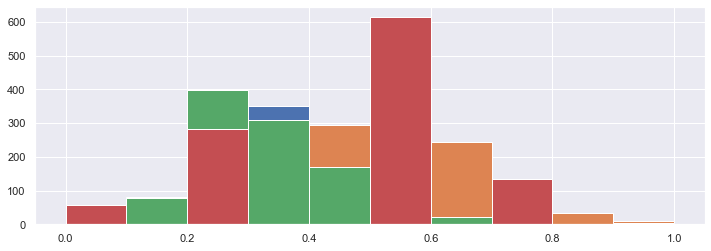

In [8]:
### MinMaxScaler
fig, ax = plt.subplots(figsize=(12, 4))

scaler = MinMaxScaler()
x_minmax_train = scaler.fit_transform(x_train)

### Scale test set
x_minmax_test = scaler.fit_transform(x_test)

ax.hist(x_minmax_train [:,0]);
ax.hist(x_minmax_train [:,1]);
ax.hist(x_minmax_train [:,2]);
ax.hist(x_minmax_train [:,3]);

### Linear Regression

In [9]:
reg = LinearRegression()
reg.fit(x_minmax_train, y_train)
print(f'Linear Regression coefficients: {reg.coef_}')
print(f'Linear Regression intercept: {reg.intercept_}')

# model evaluation for training set
y_train_predict = reg.predict(x_minmax_train)

# calculating the intercept and slope for the regression line
b, m = np.polynomial.polynomial.polyfit(y_train, y_train_predict, 1)

Linear Regression coefficients: [369336.11289495 194749.2201558  -33268.01068448  57680.47800717]
Linear Regression intercept: -69760.70997771356


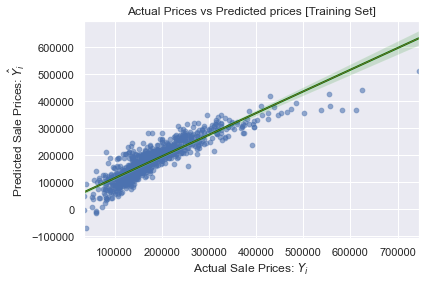

In [10]:
sns.scatterplot(x=y_train, y=y_train_predict, alpha=0.4)
sns.regplot(x=y_train, y=y_train_predict, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train), y=np.unique(np.poly1d(b + m * np.unique(y_train))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices: $Y_i$")
plt.ylabel("Predicted Sale Prices: $\hat{Y}_i$")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

### Lasso regression

In [11]:
lasso_reg = Lasso(normalize=True)
lasso_reg.fit(x_minmax_train,y_train)
print(f'Linear Regression coefficients: {lasso_reg.coef_}')
print(f'Linear Regression intercept: {lasso_reg.intercept_}')

# model evaluation for training set
y_train_predict = lasso_reg.predict(x_minmax_train)

# calculating the intercept and slope for the regression line
b, m = np.polynomial.polynomial.polyfit(y_train, y_train_predict, 1)

Linear Regression coefficients: [368087.22197501 194694.08842726 -31997.89733344  57581.32843085]
Linear Regression intercept: -69676.92363986775


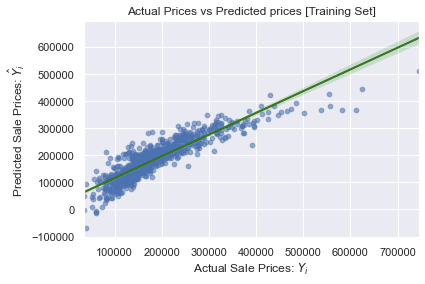

In [12]:
sns.scatterplot(x=y_train, y=y_train_predict, alpha=0.4)
sns.regplot(x=y_train, y=y_train_predict, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train), y=np.unique(np.poly1d(b + m * np.unique(y_train))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices: $Y_i$")
plt.ylabel("Predicted Sale Prices: $\hat{Y}_i$")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

## 4. Evaluate polynomial, indicator, dichotomous, & piecewise model components

### Polynomial Regression

In [13]:
"Creates a polynomial regression model for the given degree"
poly_features = PolynomialFeatures(degree=2)
   
# transform the features to higher degree features.
X_train_poly = poly_features.fit_transform(x_minmax_train)
   
# fit the transformed features to Linear Regression
poly_model = LinearRegression()

poly_model.fit(X_train_poly, y_train)
     
# predicting on training data-set
y_train_predicted = poly_model.predict(X_train_poly)
   
# predicting on test data-set
y_test_predicted = poly_model.predict(poly_features.fit_transform(x_test))

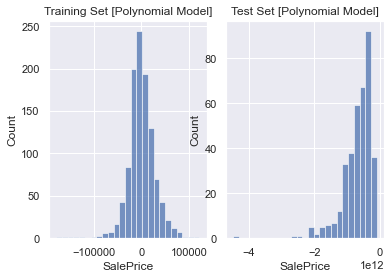

In [14]:
y_train_residual = y_train_predicted - y_train
y_test_residual = y_test_predicted - y_test


fig, axes = plt.subplots(2, 1)
# Adjust the subplot layout parameters
fig.subplots_adjust(hspace=0.125, wspace=0.125)

plt.subplot(1, 2, 1)
sns.histplot(y_train_residual, bins=25)
plt.title('Training Set [Polynomial Model]')

plt.subplot(1, 2, 2)
sns.histplot(y_test_residual, bins=25)
plt.title('Test Set [Polynomial Model]')

plt.show()

### Indicator